In [16]:
## Import modules 
%load_ext autoreload
%autoreload 2
import os 

import pandas as pd
import numpy as np 
import torchvision 
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import Dataset
from torchvision import transforms, utils, datasets, models
from PIL import Image 
from torchsummary import summary 

In [2]:
## Unzip the Dataset in the raw data folder using the script - unzip.py 
#!python scripts/unzip.py 

In [3]:
## Run this to set the project framework 
## This will empty the folders with images in them if they exist then build a new folder structure before copying data from 
## unzipped file structure and randomly assigning it to train, test, validate for the different clinics 
## it should take approx 15 mins to complete. There will be a printed output of the numbers of images from the different folders. 
## Only run this once - if you've run it comment out this line. 
# !python scripts/train_test_split.py 

In [25]:
## Create a Data loader for clinic 0 - the first clinic using the folder structure created above 

class GasHistDS(Dataset):
    def __init__(self, image_path, transform = None):
        super(GasHistDS, self). __init__()
        self.image_path = image_path
        self.data = datasets.ImageFolder(image_path)
        self.transform = transform

    def __getitem__(self, idx):
        img, tgt = self.data[idx]
        img = np.array(img).astype(np.float32)
        tgt = np.array(tgt).astype(np.float32)
     
        ## image to tensor 
        img = torch.Tensor(img).permute(2,0,1)
        ## conduct transform after img is a tensor 
        if self.transform is not None:
            img = self.transform(img)
        tgt = torch.Tensor(tgt)
        return img, tgt 
    
    def __len__(self):
        return len(self.data)


In [28]:
from torchvision.transforms import v2

train_img_folder = '../data/processed/clin_0/train'
val_img_folder = '../data/processed/clin_0/validate'

xform = v2.Compose([
    v2.CenterCrop(size=(224,224)),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_data = GasHistDS(train_img_folder, xform)
## only use standard xforms in the validation dataset for consistency 
val_data = GasHistDS(val_img_folder, xform) 

print(len(train_data)) 
print(len(val_data))


42911
15326


In [29]:
## Create a data loader 

import torch.utils
B = 8

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = B,
    shuffle = True)
    # pin_memory = True)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size = B,
    shuffle = False)
    # pin_memory = True) ## no requirement to shuffle data during validation 

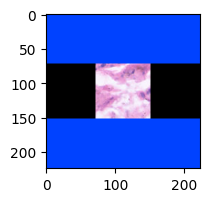

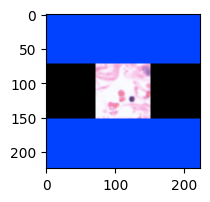

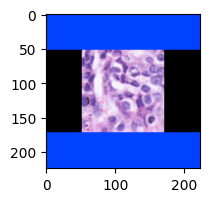

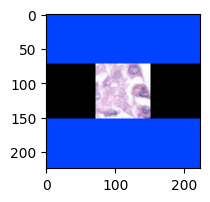

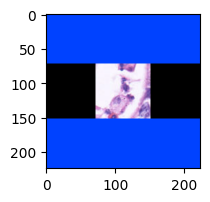

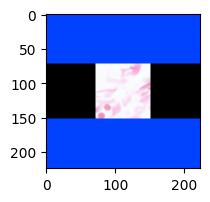

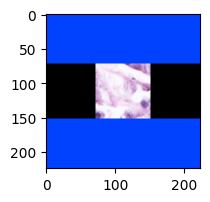

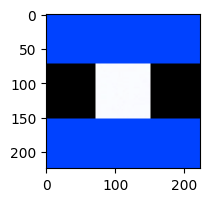

In [35]:
## Inspect images from Data Loader 
plt.rcParams["figure.figsize"] = (2,2)
inputs, labels = next(iter(train_loader))
for img in inputs:
    image = img.cpu().numpy()
    image = image.T

    data_min = np.min(image, axis=(1,2), keepdims=True)
    data_max = np.max(image, axis=(1,2), keepdims=True)
    scaled_data = (image - data_min) / (data_max - data_min)
    # show image

    plt.imshow(scaled_data)
    plt.show()


In [36]:
## Build model and test training
## Import model - use the standard weights as a start point 

model_vgg = models.vgg16(weights = 'IMAGENET1K_V1')
## inspect the model features 
model_vgg.features 



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [70]:
## Import mobilenet model 

model_mobilenet = torchvision.models.mobilenet_v3_small(weights = 'MobileNet_V3_Small_Weights.IMAGENET1K_V1')

## Freeze all params for the model 
for params in model_mobilenet.parameters():
    params.requires_grad_ = False 

## Inspect the current structure of the classifier 
model_mobilenet 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [71]:

## Build the new classifier 
bin_class = torch.nn.Sequential(
    torch.nn.Linear(in_features = 576, out_features = 288, bias = True),
    torch.nn.Hardswish(),
    torch.nn.Dropout(p=.02, inplace = True),
    torch.nn.Linear(in_features = 288, out_features = 2, bias = True))

In [73]:
## Replace the classifier on mobilenet 

model_mobilenet.classifier = bin_class
model_mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [37]:
## Inspect the model dimensions and freeze the model layers 
from torchsummary import summary 
## Freeze all layers of the model 
## Freeze all params less the classifier 
for param in model_vgg.parameters(): 
    ## consider using ''features.parameters'' above if results are poor
    param.requires_grad = False
model_vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [38]:
## Inspect the classifier and implement a new classifier

model_vgg.classifier

output_classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 25088, out_features = 4096, bias = True),
    torch.nn.ReLU(inplace = True),
    torch.nn.Dropout(p = 0.5, inplace = False),
    torch.nn.Linear(in_features = 4096, out_features = 1024, bias = True),
    torch.nn.ReLU(inplace = True),
    torch.nn.Dropout(p = 0.5, inplace = False),
    ## extra layer added in to reduce step down - drop out also included
    ## for experimentation purposes 
    torch.nn.Linear(in_features = 1024, out_features = 2, bias = True),
)

## replace the existing classifier with the new one created 

model_vgg.classifier = output_classifier
## check new structure 
summary(model_vgg.cuda(), 
        input_size = (3,224,224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [74]:
## set the device to enable GPU on local machine 
import torch 
if torch.cuda.is_available():
    Device = torch.device("cuda")
else:
    Device = torch.device("cpu")

print(Device)
print(torch.cuda.get_device_name())
print(torch.cuda.current_device())

cuda
NVIDIA GeForce RTX 4060
0


In [75]:
## Set the parameters for training the mode and import the model script 

### Loss and Optimiser 
loss_fn = torch.nn.BCEWithLogitsLoss()
learning_rate = 0.001 ## first learning rate for experimentation  
optimser = torch.optim.Adam(params = model_mobilenet.parameters(), lr = learning_rate)
epochs = 5
## put the model on the GPU 
model = model_mobilenet.to(Device)
## train the model from train script 



In [76]:
import train 
train.train(model = model_vgg,
            train_dataloader = train_loader,
            test_dataloader = val_loader,
            optimizer = optimser,
            loss_fn = loss_fn,
            epochs = epochs,
            device = Device)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([8, 3, 224, 224])
torch.Size([8])
torch.Size([8, 2])
tensor([[ 24.7770,  -5.8126],
        [ 21.9670,   2.1227],
        [  5.8812, -22.1876],
        [ 16.5039, -14.3396],
        [  7.6360, -11.4899],
        [ 17.4478,  -0.2991],
        [ 12.9431,  -4.8018],
        [  0.1676, -22.4129]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([8])
tensor([1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')


ValueError: Target size (torch.Size([8, 1])) must be the same as input size (torch.Size([8, 2]))

In [15]:
x = [1,2,3,4,5,6,7,8]
x = torch.tensor(x)
print(x.float().unsqueeze(-1))
print(x.shape)
print(x)
x = x.unsqueeze(-1)
print(x.shape)
print(x)
x = x.squeeze(-1)
print(x.shape)
print(x)
x = x.cuda()
x.is_cuda 

tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.]])
torch.Size([8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
torch.Size([8, 1])
tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]])
torch.Size([8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])


True

In [1]:
import torch 
torch.cuda.ipc_collect()
torch.cuda.empty_cache()